<a href="https://colab.research.google.com/github/dmamayeva/Notebooks/blob/main/sed_base_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework

You need to train the model and get score as big as you can

Dataset: https://disk.yandex.ru/d/gcGKZ_KsXZN4VA

### Prepare part

In [ ]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

from IPython.display import clear_output

%matplotlib inline

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/gcGKZ_KsXZN4VA'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O data.tar.gz "{download_url}"
!tar -xf data.tar.gz

Streaming output truncated to the last 5000 lines.
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar

In [ ]:
DEVICE = 'cuda' # also you can use "cuda" for gpu and "mps" for apple silicon
DATADIR = 'ml_trains_data'
LOADER_WORKERS = 0

In [ ]:
class Dataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, feats: nn.Module, read_labels=True):
        super().__init__()
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t')
        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}
        else:
          labels = {}
        self._classes = len(labels)
        self._feats = feats
        self._ytids = []
        self._pathes = []
        self._labels = []
        for _, row in data.iterrows():
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)

    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err
        assert sample_rate == 16000
        assert waveform.shape[0] == 1
        feats = self._feats(waveform)[0]
        return (feats, self._labels[index])

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes


def collate_fn(batch):
    max_length = max(item[0].shape[1] for item in batch)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return (X, targets)

### Feats part

In [ ]:
# Try to use LogMelSpectrogram or MFCC to achive better score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T

class LogMelSpectrogram(nn.Module):
    def __init__(self,
                 sample_rate=16000,
                 n_mels=128,
                 n_fft=2048,
                 hop_length=512,
                 window_fn=torch.hann_window,
                 power=2.0,
                 normalized=False,
                 center=True,
                 pad_mode='reflect',
                 top_db=80.0,
                 eps=1e-6
                 ):

        super(LogMelSpectrogram, self).__init__()


        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.top_db = top_db
        self.eps = eps


        self.spectrogram = T.Spectrogram(
            n_fft=n_fft,
            hop_length=hop_length,
            window_fn=window_fn,
            power=power,
            normalized=normalized,
            center=center,
            pad_mode=pad_mode
        )

        self.mel_scale = T.MelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            n_stft=n_fft // 2 + 1
        )

    def forward(self, x):

        spec = self.spectrogram(x)


        mel_spec = self.mel_scale(spec)

        log_mel_spec = torch.log(torch.clamp(mel_spec, min=self.eps))

        if self.top_db is not None:
            log_mel_spec = torch.max(log_mel_spec,
                                     log_mel_spec.max() - self.top_db)

        return log_mel_spec

    def extra_repr(self):
        return (f"sample_rate={self.sample_rate}, "
                f"n_mels={self.n_mels}, "
                f"n_fft={self.n_fft}, "
                f"hop_length={self.hop_length}")

FEATS = 40
transform = torchaudio.transforms.MelSpectrogram(n_mels=FEATS)
trainset = Dataset('train', '/content/ml_trains_data', transform)
testset = Dataset('eval', '/content/ml_trains_data', transform, read_labels=False)
N_CLASSES = trainset.classes()
assert N_CLASSES == 30

In [ ]:
sample = trainset[0]
sample[0].shape

torch.Size([40, 801])

### Eval part

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [ ]:
# Get list of pairs (target_class, predicted_class)
def balanced_accuracy(items: list[tuple[int, int]], classes=N_CLASSES) -> float:
  bacc = sum([sum([1 for i, j in items if i==c and i==j])/sum([1 for i, j in items if i==c]) for c in range(classes)])
  return bacc/classes

In [ ]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)], 2), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)], 2), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)], 2), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)], 3), 0.66666666666666)

### Train part
Train some model with as big balanced accuracy as you can

You can train any model you want. The only limitation is that it must be trained from scratch on the data provided in the task. For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

Hints:
- No need to train large models for this task. 10 million parameters is more than you need.
- Watch to overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Try different features (mel-spec, log-mel-spec, mfcc)

In [ ]:
def stage(
    model: nn.Module,
    data: torch_data.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 256,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        pred = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    opt,
    batch_size: int = 128,
    epochs: int = 10,
):
    train_data, val_data = torch.utils.data.random_split(trainset, (0.9, 0.1), generator=torch.Generator().manual_seed(42))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = stage(model, train_data, opt, batch_size=batch_size)
        val_loss, val_acc = stage(model, val_data, opt, batch_size=batch_size, train=False)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), val_losses, label='val')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(1, epoch + 2), val_accs, label='val')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {val_loss}. Test accuracy {val_acc}')

In [ ]:
import torch
import torch.nn as nn

class SEDModel(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(SEDModel, self).__init__()

        self.dnn = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )


        self.cnn1d = nn.Sequential(
            nn.Conv1d(in_channels=40, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )


        self.cnn2d = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )


        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=4, dim_feedforward=128, dropout=0.3
        )
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)


        self.fc = nn.Sequential(
            nn.Linear(64, out_dim)
        )

    def forward(self, x):
      # DNN
      batch_size, channels, timesteps = x.shape
      x_dnn = x.permute(0, 2, 1)  # (batch_size, timesteps, channels)
      x_dnn = self.dnn(x_dnn.reshape(-1, channels))  # Flatten for DNN
      x_dnn = x_dnn.reshape(batch_size, timesteps, -1)  # Reshape back

      # CNN1D
      x_cnn1d = self.cnn1d(x)

      # CNN2D
      x_cnn2d = x.unsqueeze(1)  # Add channel dimension for CNN2D
      x_cnn2d = self.cnn2d(x_cnn2d)
      x_cnn2d = x_cnn2d.view(batch_size, 64, -1)  # Flatten for Transformer

      # Transformer
      x_transformer = x_cnn2d.permute(2, 0, 1)  # (seq_len, batch_size, d_model)
      x_transformer = self.transformer(x_transformer)
      x_transformer = x_transformer.permute(1, 0, 2).mean(dim=1)  # Global pooling

      # Output
      output = self.fc(x_transformer)
      return output


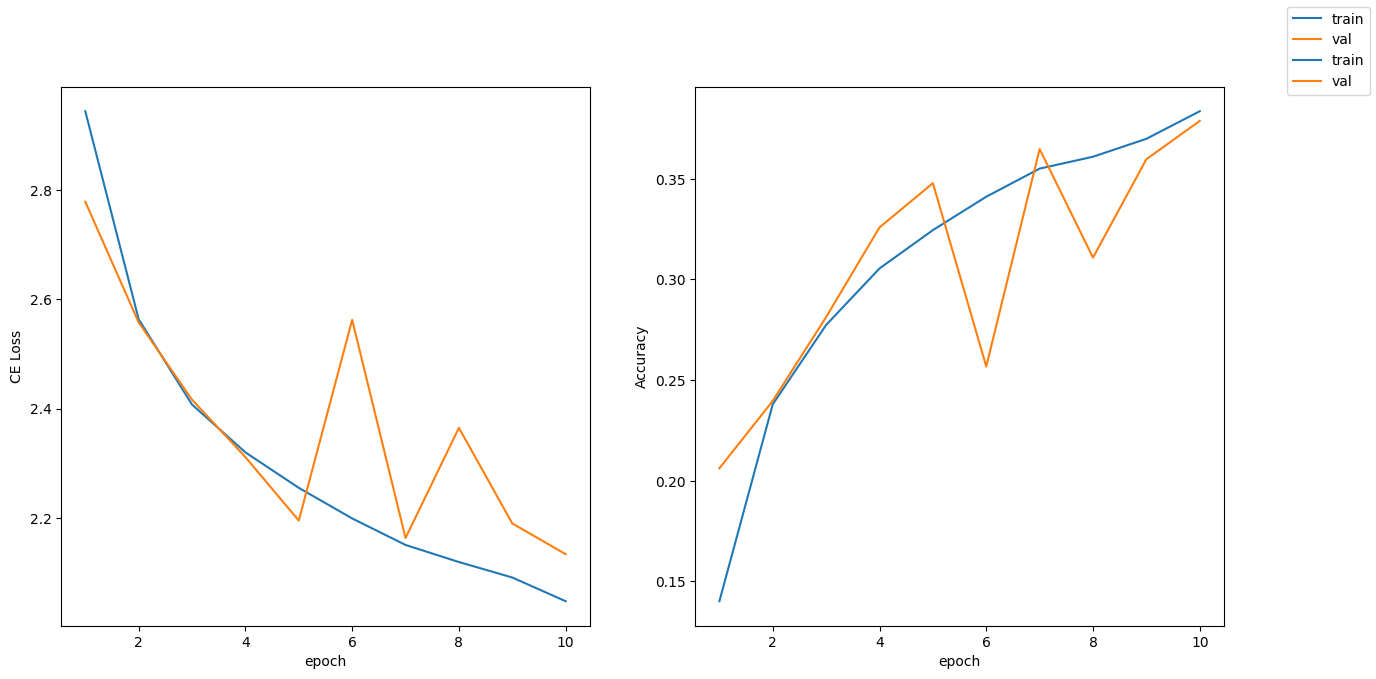

Epoch 10.
Train loss 2.046985233983686. Train accuracy 0.3835113161617907.
Test loss 2.1331429481506348. Test accuracy 0.3786908987586116


In [ ]:
model = SEDModel(40, N_CLASSES).to(DEVICE)
opt = optim.Adam(model.parameters())
train(model, opt,batch_size = 256)

### Prediction part

Prepare result file and send it to Yandex.Contest

In [ ]:
result = []
for idx, ytid in enumerate(testset._ytids):
    feats, _ = testset[idx]
    predict = torch.argmax(model.forward(feats.reshape(1, FEATS, -1).to(DEVICE)), dim=1).item()
    result.append((ytid, trainset._idx_to_label[predict]))
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result.tsv', sep='\t', index=False)